In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('mnist_train.csv')

In [3]:
images = raw_data.iloc[:,1:].values
images = images.astype(float)
images = np.multiply(images, 1.0/255.0)
size = int(np.sqrt(len(images[0])))
images = [img.reshape((size, size)) for img in images]

labels = raw_data.iloc[:,0].values
print(labels[1])

4


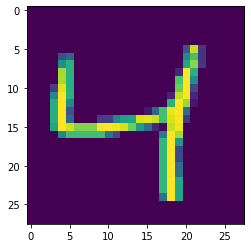

In [4]:
plt.imshow(images[1])

### Cool, so our images are 28x28x1 arrays. This should be a little easier than RGB.

Let's just rebuild our CNN from scratch

In [14]:
class ConvLayer:
    def __init__(self, num_filters, filter_size, strides=1):
        self.num_filters = num_filters
        self.strides = strides
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size) / (filter_size*filter_size)
        
    def patch_generator(self, image):
        height, width = image.shape
        self.image = image
        
        out_height, out_width, num_filters = self.out_size
        
        # iterate over image, yielding patches as we go
        for i in range(out_height):
            for j in range(out_width):
                image_patch = image[i:i+self.filter_size, j:j+self.filter_size]
                yield image_patch, i, j
                
    
    def forward_prop(self, image):
        height, width = image.shape
        self.out_size = (int((height - self.filter_size) / self.strides + 1), int((width - self.filter_size) / self.strides + 1), self.num_filters)
        conv_out = np.zeros(self.out_size)
        
        for image_patch, i, j in self.patch_generator(image):
            conv_out[i, j] = np.sum(image_patch * self.filters, axis=(1,2))
        
        return conv_out
    
    
    def backward_prop(self, dL_dout, learning_rate):
        dL_dW_params = np.zeros(self.filters.shape)
        
        for image_patch, i, j in self.patch_generator(self.image):
            for f in range(self.num_filters):
                dL_dW_params[f] += image_patch * dL_dout[i,j,f]
            
        self.filters -= learning_rate*dL_dW_params
        
        return dL_dW_params
    


In [15]:
# Quick forward propagation test

D = ConvLayer(num_filters=4, filter_size=2)
out = D.forward_prop(images[0])
print(out.shape)

(27, 27, 4)


In [16]:
class MaxPoolLayer:
    def __init__(self, filter_size):
        self.filter_size = filter_size
        
    def patch_generator(self, image):
        self.image = image
        out_height, out_width, out_depth = self.out_size
        
        for i in range(out_height):
            for j in range(out_width):
                image_patch = image[(i*self.filter_size):(self.filter_size*(i+1)), (j*self.filter_size):(self.filter_size*(j+1))]
                yield image_patch, i, j
        
    def forward_prop(self, image):
        inp_height, inp_width, inp_num_filters = image.shape
        self.out_size = ((inp_height // self.filter_size), (inp_width // self.filter_size), inp_num_filters)
        out = np.zeros(self.out_size)
        
        for patch, i, j in self.patch_generator(image):
            out[i, j] = np.amax(patch, axis=(0,1))
        
        return out
    
    def backward_prop(self, dL_dout):
        dL_dMP = np.zeros(self.image.shape)
        
        for patch, i, j in self.patch_generator(self.image):
            ph, pw, pf = patch.shape
            max_val = np.amax(patch, axis=(0,1))
            
            # Here we only want the gradient that corresponds to the
            # maximum value from the input image to be updated
        
            for h in range(ph):
                for w in range(pw):
                    for f in range(pf):
                        if patch[h,w,f] == max_val[f]:
                            dL_dMP[i*self.filter_size + h, j*self.filter_size + w, f] = dL_dout[i,j,f]
            
            return dL_dMP
            

In [17]:
# Test out forward prop thru maxpool
MP = MaxPoolLayer(2)
mp_out = MP.forward_prop(out)
print(mp_out.shape)

(13, 13, 4)


In [18]:
class SoftmaxLayer:
    def __init__(self, num_inputs, num_classes):
        self.weights = np.random.randn(num_inputs, num_classes) / num_inputs
        self.biases = np.zeros(num_classes)
        
        
    def forward_prop(self, image):
        self.orig_img_shape = image.shape
        flattened = image.flatten()
        self.flattened = flattened
        out = np.dot(flattened, self.weights) + self.biases
        self.out = out
        exp_out = np.exp(out)
        
        return exp_out / np.sum(exp_out, axis=0)
    
    def backward_prop(self, dL_dout, learning_rate):
        
        # The gradient here will be the -log of our predicted y
        # The rest of the values will be 0
        for i, gradient in enumerate(dL_dout):
            if gradient == 0:
                continue
                
            exp = np.exp(self.out)
            S_total = np.sum(exp)
            
            # case 2: i != l
            dy_dz = -exp[i] * exp / (S_total**2)
            
            # case 1: i == l (this is equiv. to y*(1-y))
            dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)
            
            # dz_dw, dz_db, dz_dinput
            dz_dw = self.flattened
            dz_db = 1
            dz_dinput = self.weights
            
            # grad is dL_dy
            # dL/dz = dL/dy * dy/dz
            dL_dz = gradient * dy_dz
            
            # loss wrt. weights, biases, input
            dL_dW = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
            dL_db = dL_dz * dz_db
            dL_dinput = dz_dinput @ dL_dz
            
            # update weights and biases
            self.weights = self.weights - (learning_rate * dL_dW)
            self.biases = self.biases - (learning_rate * dL_db)
            
            return dL_dinput.reshape(self.orig_img_shape)
            

In [19]:
from math import prod

SM = SoftmaxLayer(num_inputs=prod(mp_out.shape), num_classes=10)
sm_out = SM.forward_prop(mp_out)
print(sm_out)

[0.10002007 0.09945614 0.10014249 0.09981342 0.09977065 0.09931503
 0.10020608 0.10049994 0.10106636 0.09970982]


## This softmax output is promising
This is actually way more promising than the CIFAR CNN at this stage

The output of the softmax *should* look like this (approx. equal probabilities because we have done zero training), and on the CIFAR it looked far more random than this.

So maybe I have something wrong with my forward propagation on the other attempt.

In [20]:
# Moment of truth: backpropagation

image_label = labels[0]
num_classes = 10
learning_rate = 0.005

# Cross-entropy-loss
def initial_gradient (sm_out, image_label):
    cross_entropy_loss = -np.log(sm_out[image_label])
    acc = 1 if np.argmax(sm_out) == image_label else 0

    gradient = np.zeros(num_classes)
    gradient[image_label] = -1 / sm_out[image_label]
    
    return gradient

gradient = initial_gradient(sm_out, image_label)

gradient = SM.backward_prop(gradient, learning_rate)
print(gradient.shape)
gradient = MP.backward_prop(gradient)
print(gradient.shape)
gradient = D.backward_prop(gradient, learning_rate)
print(gradient.shape)

(13, 13, 4)
(27, 27, 4)
(4, 2, 2)


In [21]:
# Second moment of truth: feeding in a 2nd image

img2 = images[2]
label = labels[2]

fwd = D.forward_prop(img2)
fwd = MP.forward_prop(fwd)
fwd = SM.forward_prop(fwd)
print(fwd)

gradient = initial_gradient(fwd, label)

back = SM.backward_prop(gradient, learning_rate)
back = MP.backward_prop(back)
back = D.backward_prop(back, learning_rate)
print(back.shape)

[0.10212861 0.09944136 0.10015389 0.09974955 0.09962152 0.1002198
 0.09977817 0.09977813 0.09956042 0.09956855]
(4, 2, 2)


### Alright! No real change but no exploding/vanishing gradient immediately, so we'll train on many images and see what happens

In [24]:
# This is partly reused code from cnn_cifar.ipynb

class CNNModel:
    def __init__(self, layers, num_classes, learning_rate=0.005):
        assert len(layers) >= 1
        self.layers = layers
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        
    def forward_prop(self, image, label):
        out_forward = self.layers[0].forward_prop(image)
        for layer in self.layers[1:]:
            out_forward = layer.forward_prop(out_forward)
        
        cross_entropy_loss = -np.log(out_forward[label])
        accuracy = 0
        if np.argmax(out_forward) == label:
            accuracy = 1
        
        return out_forward, cross_entropy_loss, accuracy
    
    def backward_prop(self, initial_gradient):
        back_gradient = self.layers[-1].backward_prop(initial_gradient, self.learning_rate)
        for layer in reversed(self.layers[:-1]):
            if isinstance(layer, MaxPoolLayer):
                back_gradient = layer.backward_prop(back_gradient)
            else:
                back_gradient = layer.backward_prop(back_gradient, self.learning_rate)
    
    def train_image(self, image, label):
        
        # Forward propagation
        out_fw, loss, acc = self.forward_prop(image, label)
        # calc initial gradient
        gradient = np.zeros(self.num_classes)
        gradient[label] = -1 / out_fw[label]
        
        # Backward propagation
        self.backward_prop(gradient)
        
        return loss, acc
    
    def train(self, images, labels):
        loss = 0
        num_correct = 0
        for i, (img, label) in enumerate(zip(images, labels)):
            if i % 500 == 0:
                print('after {num} images, loss={loss} and correct%={correct}'.format(num=i, loss=loss, correct=(num_correct/500)))
                loss = 0
                num_correct = 0
            
            l, a = self.train_image(img, label)
            loss += l
            num_correct += a
            
    def classify(self, image, label):
        fwd_out, cel, acc = self.forward_prop(image, label)
        predicted = np.argmax(fwd_out)
        
        return predicted
    
    def assess_model(self, test_images, test_labels):
        predictions = np.zeros(len(test_images))
        num_correct = 0
        
        for i, (test_img, test_lbl) in enumerate(zip(test_images, test_labels)):
            predictions[i] = self.classify(test_img, test_lbl)
            
            if predictions[i] == test_lbl:
                num_correct += 1
        
        correct_percent = num_correct / len(test_images)
        
        return correct_percent, predictions
        

model_test = CNNModel(
    layers=[
        ConvLayer(num_filters=4, filter_size=4),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=12*12*4, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

In [25]:
loss, acc = model_test.train_image(images[0], labels[0])
print(loss, acc)

2.3003869191251365 0


In [26]:
# Let's set up some training and testing data
# images contains 59999 images

train_set = images[:50000]
train_labels = labels[:50000]

test_set = images[50000:]
test_labels = labels[50000:]

In [27]:
# Now let's train

model_test.train(train_set, train_labels)

after 0 images, loss=0 and correct%=0.0
after 500 images, loss=1094.5585054706096 and correct%=0.484
after 1000 images, loss=1015.6305741939198 and correct%=0.632
after 1500 images, loss=936.6841563193602 and correct%=0.68
after 2000 images, loss=850.0954918969437 and correct%=0.754
after 2500 images, loss=780.7521894994605 and correct%=0.774
after 3000 images, loss=730.898165698512 and correct%=0.762
after 3500 images, loss=723.4627834139749 and correct%=0.77
after 4000 images, loss=666.0953950831735 and correct%=0.794
after 4500 images, loss=636.055588921022 and correct%=0.814
after 5000 images, loss=583.6674990881046 and correct%=0.796
after 5500 images, loss=550.0295889000178 and correct%=0.784
after 6000 images, loss=551.7925508129504 and correct%=0.824
after 6500 images, loss=481.26223038733224 and correct%=0.838
after 7000 images, loss=511.5187493825767 and correct%=0.842
after 7500 images, loss=569.7972468054193 and correct%=0.812
after 8000 images, loss=507.8801211702941 and c

In [28]:
correct_percent, predictions = model_test.assess_model(test_set, test_labels)
print('% correct: ', correct_percent)

% correct:  0.890989098909891


In [29]:
model_1 = CNNModel(
    layers=[
        ConvLayer(num_filters=6, filter_size=5),
        MaxPoolLayer(3),
        SoftmaxLayer(num_inputs=8*8*6, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

model_1.train(train_set, train_labels)

after 0 images, loss=0 and correct%=0.0
after 500 images, loss=1126.3772857320073 and correct%=0.348
after 1000 images, loss=1090.6417633076665 and correct%=0.556
after 1500 images, loss=1050.7014769924986 and correct%=0.564
after 2000 images, loss=994.9852188308643 and correct%=0.696
after 2500 images, loss=953.9220341723973 and correct%=0.714
after 3000 images, loss=916.5599752146067 and correct%=0.696
after 3500 images, loss=903.4040956242077 and correct%=0.7
after 4000 images, loss=854.5350152119445 and correct%=0.732
after 4500 images, loss=833.5799448586803 and correct%=0.766
after 5000 images, loss=783.2096248990467 and correct%=0.72
after 5500 images, loss=768.5172467707195 and correct%=0.746
after 6000 images, loss=760.1845637524829 and correct%=0.796
after 6500 images, loss=706.2733494066116 and correct%=0.812
after 7000 images, loss=702.3951003333918 and correct%=0.784
after 7500 images, loss=737.81765571823 and correct%=0.762
after 8000 images, loss=685.9998499985371 and co

In [31]:
correct_percent_model1, predictions_model1 = model_1.assess_model(test_set, test_labels)
print('% correct: ', correct_percent_model1*100, '%')

% correct:  89.39893989398941 %


In [35]:
# A slightly larger model (more filters, larger filters)

model_2 = CNNModel(
    layers=[
        ConvLayer(num_filters=10, filter_size=8),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=10*10*10, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

model_2.train(train_set, train_labels)

after 0 images, loss=0 and correct%=0.0
after 500 images, loss=1125.6132955178307 and correct%=0.45
after 1000 images, loss=1087.9466433740704 and correct%=0.566
after 1500 images, loss=1047.214278410815 and correct%=0.578
after 2000 images, loss=997.327832203414 and correct%=0.698
after 2500 images, loss=952.6302266231811 and correct%=0.71
after 3000 images, loss=914.2831812839671 and correct%=0.692
after 3500 images, loss=893.7848598151875 and correct%=0.706
after 4000 images, loss=850.2945348057062 and correct%=0.73
after 4500 images, loss=814.7053563822491 and correct%=0.764
after 5000 images, loss=760.9140411064002 and correct%=0.756
after 5500 images, loss=713.3887974889847 and correct%=0.758
after 6000 images, loss=694.8483517373992 and correct%=0.788
after 6500 images, loss=618.4100718436928 and correct%=0.814
after 7000 images, loss=610.609566103251 and correct%=0.812
after 7500 images, loss=643.3862820827186 and correct%=0.794
after 8000 images, loss=568.6245501527243 and cor

In [36]:
correct_percent_model2, predictions_model2 = model_2.assess_model(test_set, test_labels)
print('% correct: ', correct_percent_model2*100, '%')

% correct:  90.25902590259027 %


In [37]:
# Let's go even larger, 

model_3 = CNNModel(
    layers=[
        ConvLayer(num_filters=15, filter_size=6),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=11*11*15, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

model_3.train(train_set, train_labels)

after 0 images, loss=0 and correct%=0.0
after 500 images, loss=1091.7414963075903 and correct%=0.476
after 1000 images, loss=1007.7420996646855 and correct%=0.61
after 1500 images, loss=929.2858608007286 and correct%=0.658
after 2000 images, loss=836.6445782527004 and correct%=0.744
after 2500 images, loss=766.8580949660654 and correct%=0.762
after 3000 images, loss=714.4706785474345 and correct%=0.762
after 3500 images, loss=701.0667892851263 and correct%=0.764
after 4000 images, loss=644.6854321386253 and correct%=0.782
after 4500 images, loss=614.0392013573736 and correct%=0.802
after 5000 images, loss=571.6754619495205 and correct%=0.79
after 5500 images, loss=537.2907482616208 and correct%=0.79
after 6000 images, loss=534.7686976558207 and correct%=0.838
after 6500 images, loss=470.89812950262086 and correct%=0.85
after 7000 images, loss=487.6380413214927 and correct%=0.84
after 7500 images, loss=544.7149994688632 and correct%=0.808
after 8000 images, loss=489.18638591483653 and c

In [38]:
correct_percent_model3, predictions_model3 = model_3.assess_model(test_set, test_labels)
print('% correct: ', correct_percent_model3*100, '%')

% correct:  89.96899689968997 %


Okay, it's looking like I can't get much better than 90%, at least by increasing the size of the models. 